# 02 Exercise FashionMNIST

PyTorch: 2.10.0+cu128
Torchvision: 0.25.0+cu128
Device: cuda
GPU disponibile: True


100%|██████████| 170M/170M [00:05<00:00, 32.0MB/s]


Training set: (50000, 32, 32, 3)
Test set: (10000, 32, 32, 3)
Range valori: [0, 255]
Classi: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


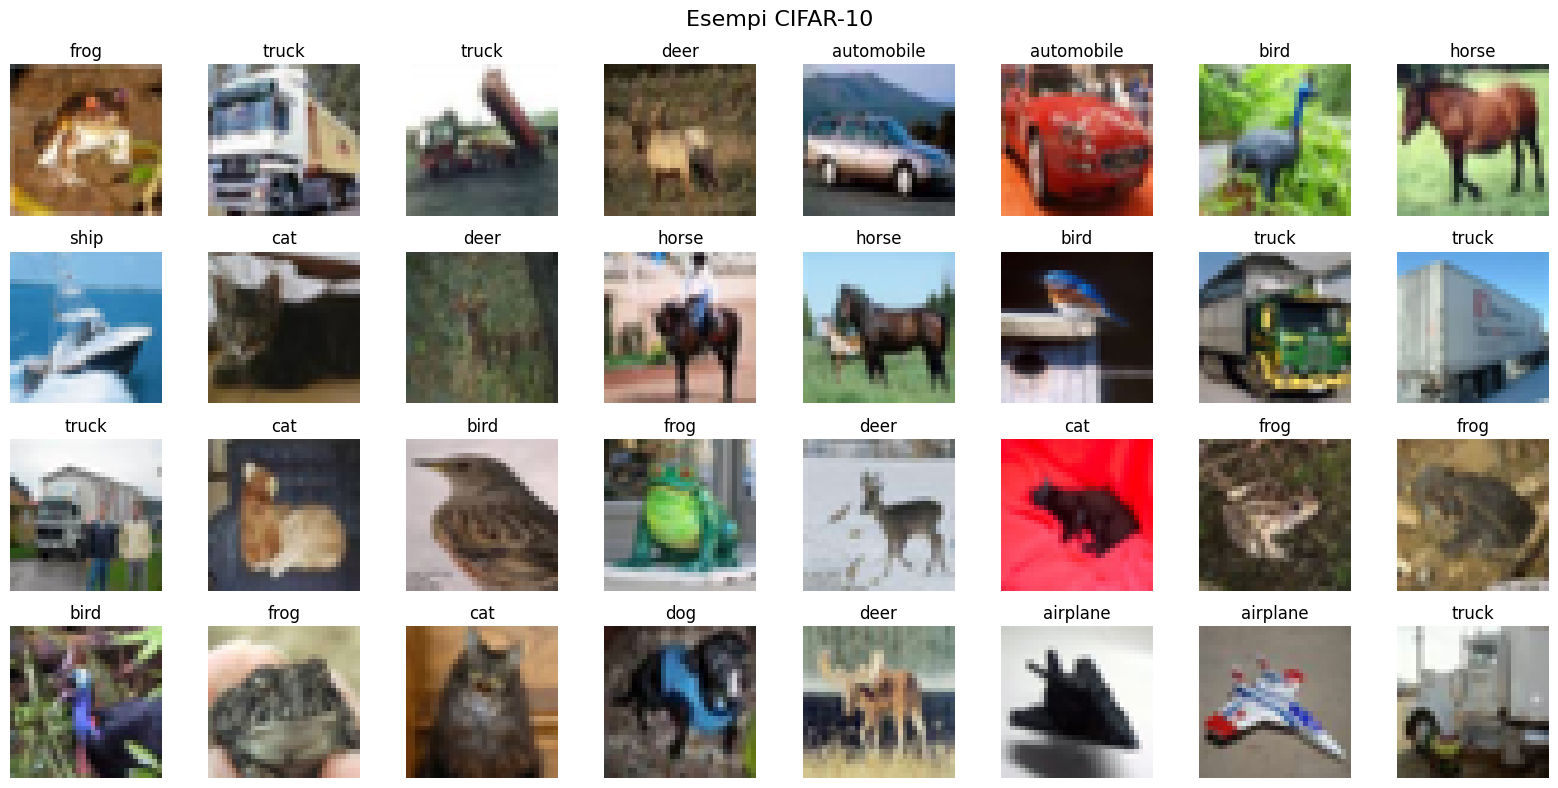

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"PyTorch: {torch.__version__}")
print(f"Torchvision: {torchvision.__version__}")
print(f"Device: {device}")
print(f"GPU disponibile: {torch.cuda.is_available()}")

# Caricamento CIFAR-10
transform_basic = transforms.ToTensor()

trainset_full = torchvision.datasets.CIFAR10(
    root='../data', train=True, download=True,
    transform=transform_basic
)
testset = torchvision.datasets.CIFAR10(
    root='../data', train=False, download=True,
    transform=transform_basic
)

# Per avere anche array numpy (utile per visualizzazioni)
trainset_raw = torchvision.datasets.CIFAR10(
    root='../data', train=True, download=True,
    transform=None
)
testset_raw = torchvision.datasets.CIFAR10(
    root='../data', train=False, download=True,
    transform=None
)

# Nomi classi CIFAR-10
class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# Estrai dati come numpy per preprocessing/visualizzazione
X_train = np.array([np.array(img) for img, _ in trainset_raw])
y_train = np.array([label for _, label in trainset_raw])
X_test = np.array([np.array(img) for img, _ in testset_raw])
y_test = np.array([label for _, label in testset_raw])

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Range valori: [{X_train.min()}, {X_train.max()}]")
print(f"Classi: {class_names}")

# Visualizzazione esempi
fig, axes = plt.subplots(4, 8, figsize=(16, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i])
    ax.set_title(class_names[y_train[i]])
    ax.axis('off')
plt.suptitle('Esempi CIFAR-10', fontsize=16)
plt.tight_layout()
plt.show()

import os, urllib.request

# GitHub Release URL for pretrained weights (update with actual URL)
WEIGHTS_BASE_URL = os.environ.get('WEIGHTS_URL', 'https://github.com/SamueleBolotta/CEAR/releases/download/v1.0/')
WEIGHTS_DIR = '../pretrained_weights'
os.makedirs(WEIGHTS_DIR, exist_ok=True)

def load_or_train(model, train_fn, weights_filename, device='cpu'):
    """Load pretrained weights if available, otherwise train and save.
    Also saves/loads training history as JSON alongside weights."""
    weights_path = os.path.join(WEIGHTS_DIR, weights_filename)
    history_path = weights_path.replace('.pt', '_history.json')

    def _load_history():
        if os.path.exists(history_path):
            import json as _json
            with open(history_path, 'r') as f:
                return _json.load(f)
        return None

    if os.path.exists(weights_path):
        model.load_state_dict(torch.load(weights_path, map_location=device, weights_only=True))
        print(f"Loaded pretrained weights from {weights_path}")
        return _load_history()
    elif WEIGHTS_BASE_URL:
        try:
            url = WEIGHTS_BASE_URL + weights_filename
            urllib.request.urlretrieve(url, weights_path)
            try:
                urllib.request.urlretrieve(
                    WEIGHTS_BASE_URL + weights_filename.replace('.pt', '_history.json'), history_path)
            except Exception:
                pass
            model.load_state_dict(torch.load(weights_path, map_location=device, weights_only=True))
            print(f"Downloaded and loaded weights from {url}")
            return _load_history()
        except Exception as e:
            print(f"Could not download weights: {e}. Training from scratch...")

    history = train_fn()
    torch.save(model.state_dict(), weights_path)
    print(f"Saved weights to {weights_path}")
    if history is not None:
        import json as _json
        with open(history_path, 'w') as f:
            _json.dump(history, f)
        print(f"Saved training history to {history_path}")
    return history

## Esercizio 1

100%|██████████| 26.4M/26.4M [00:02<00:00, 9.90MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 212kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.95MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 13.6MB/s]


Dataset Fashion MNIST caricato
Train: (60000, 28, 28), Test: (10000, 28, 28)
Range valori originali: [0, 255]

Dopo preprocessing:
Train shape: (60000, 1, 28, 28)
Range valori: [0.00, 1.00]

Distribuzione classi nel training set:
   classe         nome  conteggio  percentuale
0       0  T-shirt/top       6000         10.0
1       1      Trouser       6000         10.0
2       2     Pullover       6000         10.0
3       3        Dress       6000         10.0
4       4         Coat       6000         10.0
5       5       Sandal       6000         10.0
6       6        Shirt       6000         10.0
7       7      Sneaker       6000         10.0
8       8          Bag       6000         10.0
9       9   Ankle boot       6000         10.0


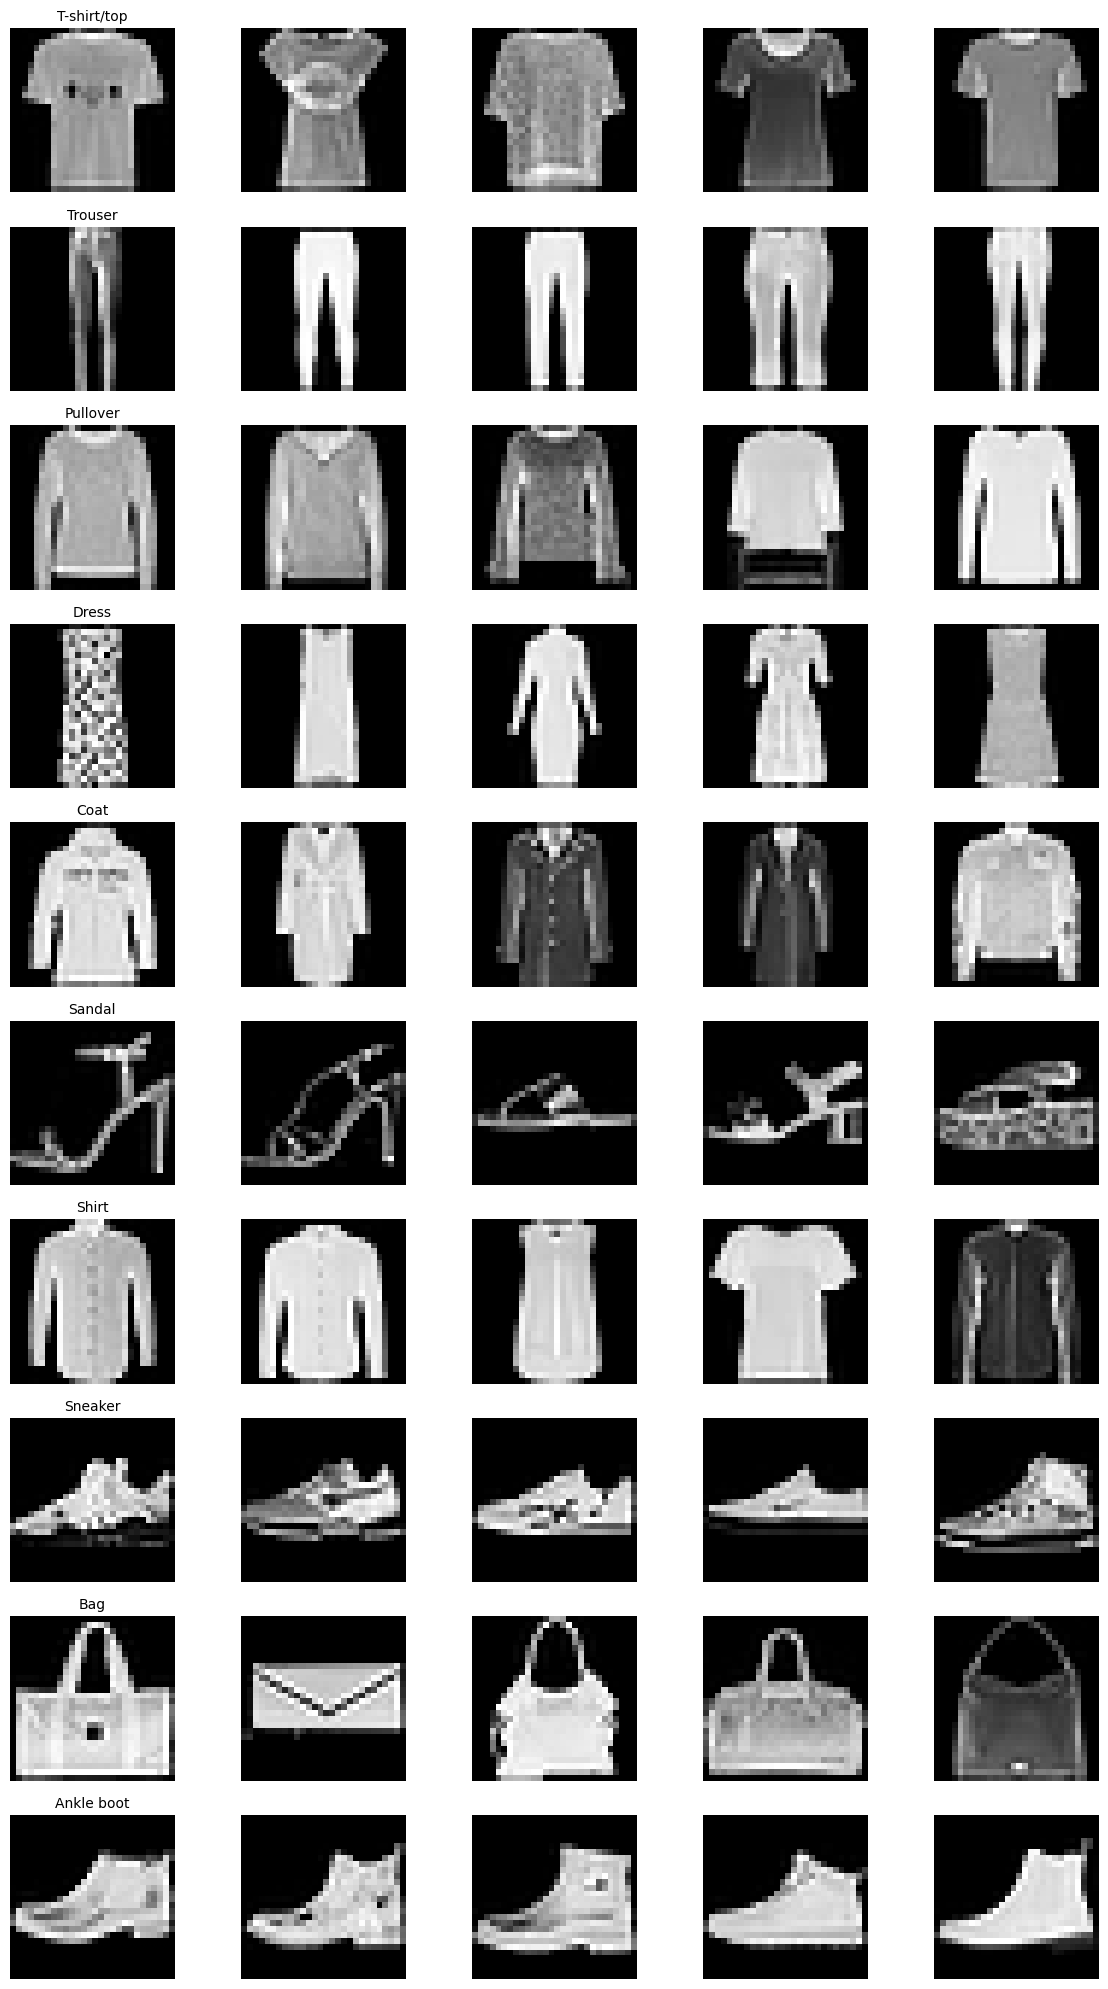


Statistiche per classe:
 classe        nome  media_pixel  std_pixel
      0 T-shirt/top     0.325608   0.350739
      1     Trouser     0.222905   0.343530
      2    Pullover     0.376701   0.358680
      3       Dress     0.258898   0.354220
      4        Coat     0.385325   0.376312
      5      Sandal     0.136735   0.263108
      6       Shirt     0.331785   0.339279
      7     Sneaker     0.167694   0.294787
      8         Bag     0.353557   0.365271
      9  Ankle boot     0.301197   0.370533


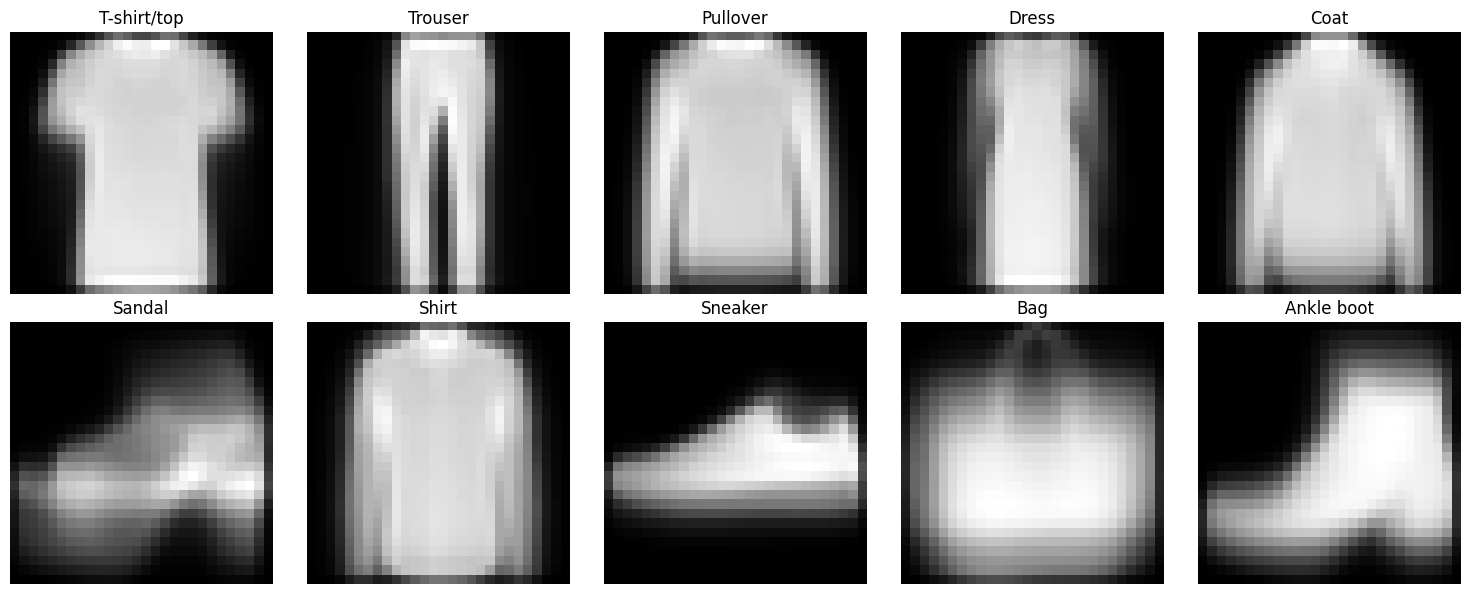

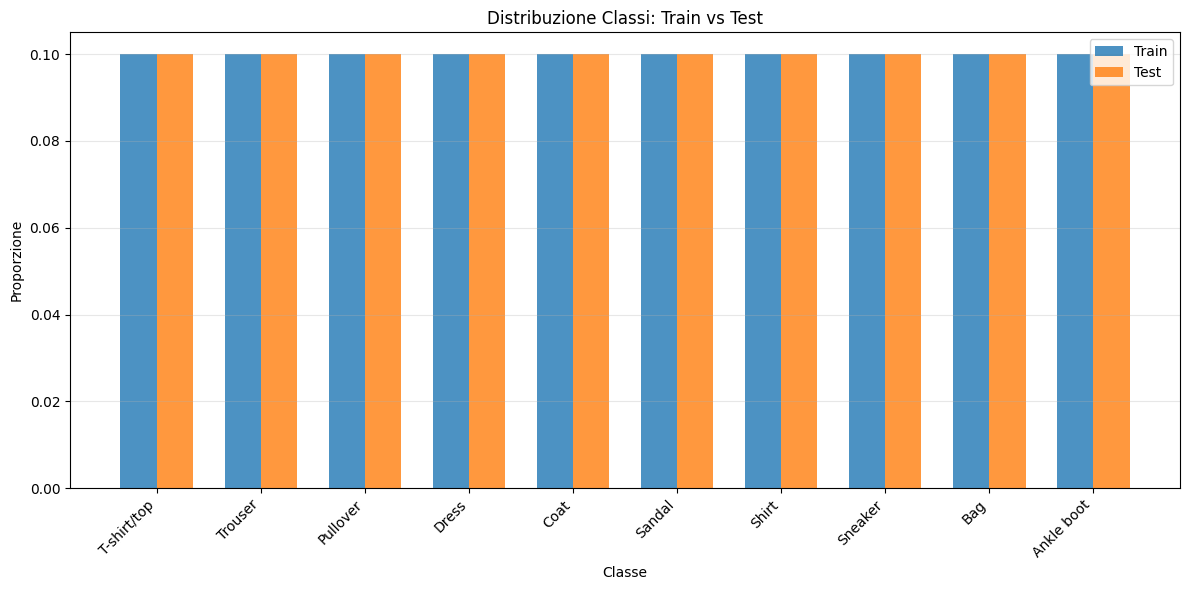


Esercizio 1 completato!


In [3]:
# ==========================================================
# ESERCIZIO 1: Preprocessing e Analisi Dataset di Immagini
# ==========================================================
# Task: Caricare, preprocessare e analizzare un dataset
#       di immagini fashion
# Dataset: Fashion MNIST (60000 immagini 28x28, 10 classi)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torchvision

# Caricamento dataset Fashion MNIST
np.random.seed(123)
fashion_train = torchvision.datasets.FashionMNIST(
    root='../data', train=True, download=True, transform=None
)
fashion_test = torchvision.datasets.FashionMNIST(
    root='../data', train=False, download=True, transform=None
)

X_train_fashion = np.array([np.array(img) for img, _ in fashion_train])
y_train_fashion = np.array([label for _, label in fashion_train])
X_test_fashion = np.array([np.array(img) for img, _ in fashion_test])
y_test_fashion = np.array([label for _, label in fashion_test])

# FIX: nome variabile dedicata, non sovrascriviamo class_names
class_names_fashion = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

print("Dataset Fashion MNIST caricato")
print(
    f"Train: {X_train_fashion.shape}, "
    f"Test: {X_test_fashion.shape}"
)
print(
    f"Range valori originali: "
    f"[{X_train_fashion.min()}, {X_train_fashion.max()}]"
)

# Scrivi la tua soluzione qui
raise NotImplementedError()